# Small area processing

In [6]:
!pip install -q matplotlib-scalebar

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import matplotlib
import ipyleaflet
import sys
import os
import dask_gateway
import dask
import planetary_computer
from rechunker import rechunk
sys.path.append('../sar_snowmelt_timing')
import s1_rtc_bs_utils
import contextily as ctx
import rioxarray as rxr
import skimage
import glob
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm



In [8]:
cluster = dask_gateway.GatewayCluster(shutdown_on_close=False)
client = cluster.get_client()
cluster.adapt(minimum=10, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.b3c10c2d71e84146a33d2b04fbca089c/status


In [9]:
bbox_gdf = gpd.read_file('../input/shapefiles/mt_rainier.geojson')

In [10]:
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2015-01-01',end_time='2022-12-31',polarization='all')

/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [11]:
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

#display mask
#f,ax=plt.subplots(figsize=(8,8))
#worldcover.where(worldcover.isin(classes)).plot()

In [12]:
worldcover_ds = s1_rtc_bs_utils.get_worldcover(ts_ds)

In [13]:
ts_ds = ts_ds
ts_ds_clipped = ts_ds.sel(time=slice('2020-12-14','2021-08-01'))
time1 = pd.to_datetime(ts_ds_clipped.isel(time=0).time.values).strftime('%Y-%m-%d')
time2 = pd.to_datetime(ts_ds_clipped.isel(time=-1).time.values).strftime('%Y-%m-%d')

In [14]:
#ts_ds_clipped = ts_ds.sel(time=slice('2021-01-01','2021-08-01'))

In [15]:
directory_name = 'MtRainier'

In [16]:
geotiff = glob.glob(f'../output/cascades/MtRainier/runoff_onset_2021*.tif')
filename_dem = glob.glob(f'../output/cascades/MtRainier/*dem*.tif')
filename_slope = glob.glob(f'../output/cascades/MtRainier/*slope*.tif')
filename_aspect = glob.glob(f'../output/cascades/MtRainier/*aspect*.tif')

runoff = rxr.open_rasterio(geotiff[0])
dem = rxr.open_rasterio(filename_dem[0]).squeeze()
slope = rxr.open_rasterio(filename_slope[0]).squeeze()
aspect = rxr.open_rasterio(filename_aspect[0]).squeeze()
dah = np.cos(np.deg2rad(202.5)-np.deg2rad(aspect))*np.arctan(np.deg2rad(slope))

In [17]:
#ts_ds = ts_ds.astype(np.float16)
#ts_ds_clipped = ts_ds_clipped.astype(np.float16)

In [18]:
year=2021

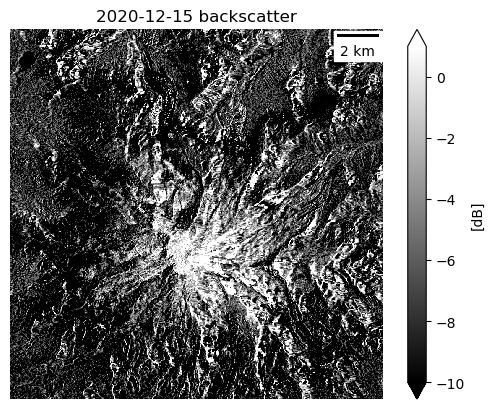

In [19]:
f,ax=plt.subplots()
(10*np.log10(ts_ds_clipped.sel(band='vv').isel(time=0))).plot(ax=ax,vmin=-10,vmax=1,cmap='gray',cbar_kwargs={'label': '[dB]'})
ctx.add_basemap(ax=ax, crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)
ax.set_title(f'{time1} backscatter')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

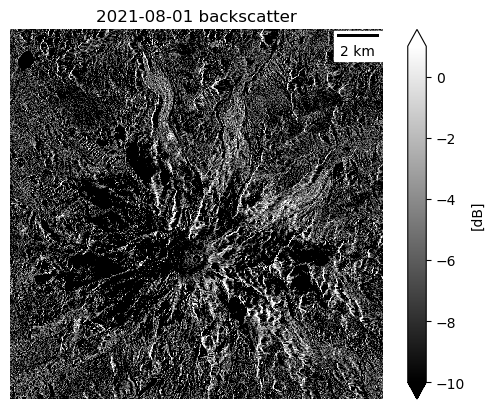

In [20]:
f,ax=plt.subplots()
(10*np.log10(ts_ds_clipped.sel(band='vv').isel(time=-1))).plot(ax=ax,vmin=-10,vmax=1,cmap='gray',cbar_kwargs={'label': '[dB]'})
ctx.add_basemap(ax=ax, crs=ts_ds_clipped.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)
ax.set_title(f'{time2} backscatter')    
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

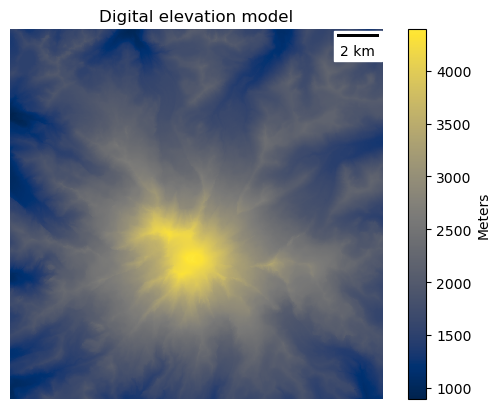

In [26]:
f,ax=plt.subplots()
dem.plot(ax=ax,cmap='cividis',cbar_kwargs={'label':'Meters'})
ax.set_title(f'Digital elevation model')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

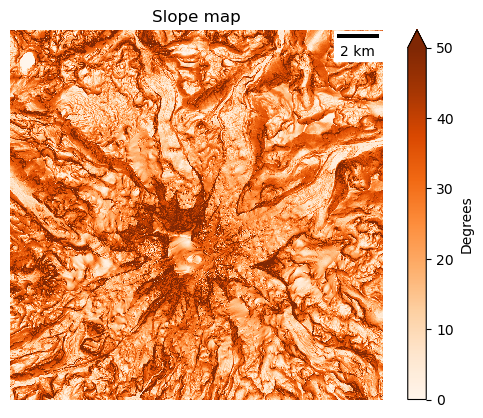

In [25]:
f,ax=plt.subplots()
slope.plot(ax=ax,vmin=0,vmax=50,cmap='Oranges',cbar_kwargs={'label':'Degrees'})
ax.set_title(f'Slope map')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

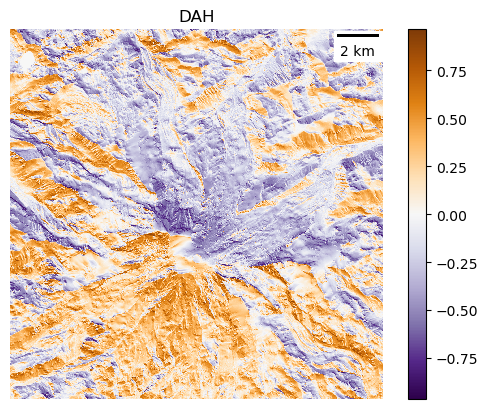

In [27]:
f,ax=plt.subplots()
dah.plot(ax=ax,cmap='PuOr_r')
ax.set_title(f'DAH')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

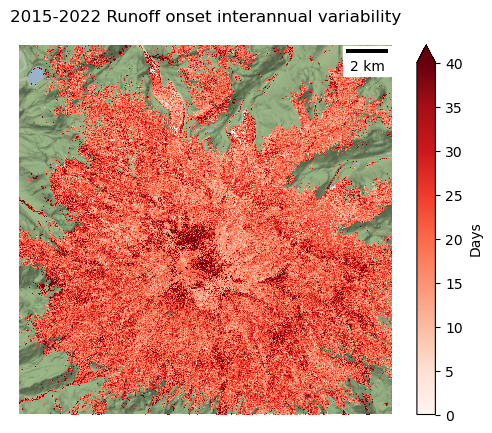

In [31]:
intvar_fn = '../output/cascades/MtRainier/runoff_onset_MtRainier_allyears_std_vvvh_10m.tif'
intvar = rxr.open_rasterio(intvar_fn)
f,ax=plt.subplots()
intvar.plot(ax=ax,cmap='Reds',vmin=0,vmax=40,cbar_kwargs={'label':'Days'})
ctx.add_basemap(ax=ax, crs=intvar.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)

ax.set_title(f'2015-2022 Runoff onset interannual variability')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

In [ ]:
hs_fn = '../output/cascades/MtRainier/hs_MtRainier_10m.tif'
hs = rxr.open_rasterio(hs_fn)

In [ ]:
bin_max = dem.max()
bin_min = dem.min()
bins = np.arange(bin_min,bin_max,100)

In [ ]:
f,ax=plt.subplots()
dem.plot(cmap='rainbow',alpha=0.5,zorder=1,cbar_kwargs={'label':'Elevation [m]'})
hs.plot(ax=ax,cmap='gray',zorder=0,add_colorbar=False)
#dem.squeeze().plot.contour(levels=bins,linewidths=0.5,colors='gray',linestyles='dashed')

ax.set_title('Shaded relief map')
ax.add_artist(ScaleBar(1.0))
ax.set_aspect('equal')
ax.axis('off')

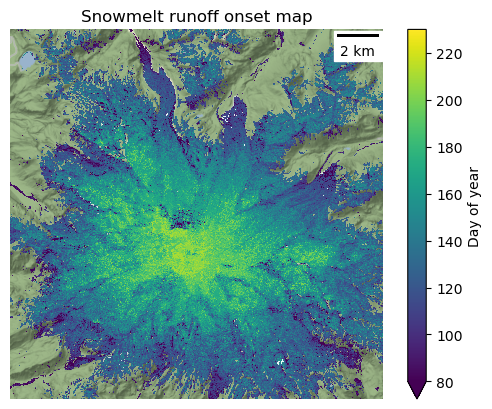

In [33]:
f,ax=plt.subplots()
ts_ds_clipped = ts_ds.where(worldcover_ds.isin(classes)).sel(time=slice('2021-01-01','2021-08-01'))
s1_rtc_bs_utils.get_runoff_onset(ts_ds_clipped,num_acquisitions_during_melt_season=5).dt.dayofyear.plot(ax=ax,cmap='viridis',vmin=80,vmax=230,cbar_kwargs={'label': 'Day of year'})
ctx.add_basemap(ax=ax, crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)
ax.set_title(f'Snowmelt runoff onset map')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/reductions.py:1071: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)


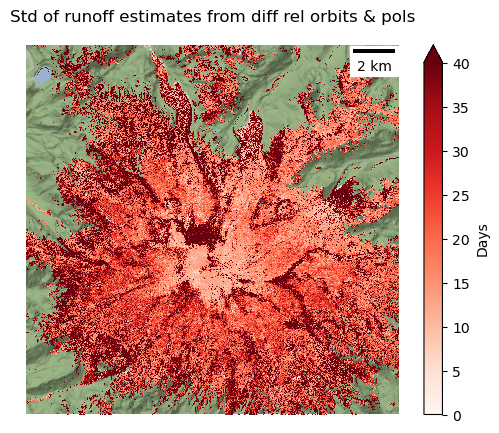

In [40]:
f,ax=plt.subplots()
s1_rtc_bs_utils.get_runoff_onset(ts_ds_clipped,return_seperate_orbits_and_polarizations=True).dt.dayofyear.std(dim=['sat:relative_orbit','band']).plot(ax=ax,cmap='Reds',vmin=0,vmax=40,cbar_kwargs={'label': 'Days'})
ctx.add_basemap(ax=ax, crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)
ax.set_title(f'Std of runoff estimates from diff rel orbits & pols')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

In [ ]:
ts_ds = ts_ds.where(worldcover_ds.isin(classes))

In [ ]:
# f,ax=plt.subplots(figsize=(12,4))

# s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(ts_ds.sel(band='vv').resample(time='2W').median(dim='time').compute(),dem,bin_size=100,ax=ax,normalize_bins=False) #normalize=False
# ax.set_title(f"Backscatter time series binned by elevation \n full Sentinel-1 catalog for context")
    
# ax.set_xlabel('Time')
# ax.set_ylabel('Elevation [m]')

In [ ]:
geotiff = glob.glob(f'../output/cascades/MtRainier/runoff_onset_2021*.tif')
filename_dem = glob.glob(f'../output/cascades/MtRainier/*dem*.tif')
filename_slope = glob.glob(f'../output/cascades/MtRainier/*slope*.tif')
filename_aspect = glob.glob(f'../output/cascades/MtRainier/*aspect*.tif')

runoff = rxr.open_rasterio(geotiff[0])
dem = rxr.open_rasterio(filename_dem[0]).squeeze().where(runoff.isel(band=0)>-1)
slope = rxr.open_rasterio(filename_slope[0]).squeeze().where(runoff.isel(band=0)>-1)
aspect = rxr.open_rasterio(filename_aspect[0]).squeeze().where(runoff.isel(band=0)>-1)


In [ ]:
# dem_and_runoff_df = pd.DataFrame((dem.data.reshape(-1),runoff.data.reshape(-1))).T.dropna()
# dem_and_runoff_df.columns = ['Elevation','Runoff DOY']

# bin_max = dem_and_runoff_df['Elevation'].max()
# bin_min = dem_and_runoff_df['Elevation'].min()
# bins = np.arange(bin_min,bin_max,100)

# runoff_elev_curve = dem_and_runoff_df.groupby(pd.cut(dem_and_runoff_df["Elevation"], bins)).median()

In [ ]:
# num_runoff = list(runoff_elev_curve['Runoff DOY'].values)
# str_runoff = [str(int(a)).rjust(3 + len(str(int(a))), '0') for a in num_runoff]

In [ ]:
# datetime_runoff = [pd.to_datetime(2021*1000 + a, format='%Y%j') for a in num_runoff]

In [ ]:
# runoff_elev_curve['date'] = datetime_runoff

In [ ]:
#runoff_elev_curve.plot(x='date',y='Elevation',label=f'Runoff onset lapse rate',c='blue',linestyle='--',legend=False)


In [ ]:
# f,ax=plt.subplots(figsize=(4,4))
# s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(ts_ds_clipped.sel(band='vv').compute(),dem,bin_size=100,ax=ax,normalize_bins=False) #normalize=False

# #ax.tick_params(axis='x', which='major')

# start_date = '2021-01-01'
# end_date = '2021-08-01'

# color = iter(cm.jet(np.linspace(0.2, 0.99, 8)))
# for i in range(7):
#     c = next(color)

# runoff_elev_curve.plot(ax=ax,x='date',y='Elevation',label=f'Runoff onset lapse rate',c=c,linestyle='-',alpha=1,legend=False)

# ax.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
# ax.set_ylim([1000,4300])

# ax.set_title(f"Backscatter time series binned by elevation \n during {year} melt season")
# ax.set_xlabel('Time')
# ax.set_ylabel('Elevation [m]')

In [ ]:
start_date = '2015-01-01'
end_date = '2022-12-31'

In [ ]:
years = [2015,2016,2017,2018,2019,2020,2021,2022]

In [ ]:
ts_ds_resampled = ts_ds.sel(band='vv').resample(time='2W').median(dim='time').compute()

In [ ]:
f,ax=plt.subplots(figsize=(12,2))


ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

julian_ax = ax.twiny()

s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(ts_ds_resampled,dem,bin_size=100,ax=ax,normalize_bins=False,add_colorbar=False) #normalize=False
#ax.set_title(f"Backscatter time series binned by elevation \n full Sentinel-1 catalog for context")



    
ax.set_xlabel('Time')
ax.set_ylabel('Elevation [m]')

color = iter(cm.jet(np.linspace(0.2, 0.99, 8)))




for year in years:
    print(f'{year}')
    c = next(color)
    geotiff = glob.glob(f'../output/cascades/MtRainier/runoff_onset_{year}_median_10m*.tif')


    
    runoff = rxr.open_rasterio(geotiff[0])

    dem_and_runoff_df = pd.DataFrame((dem.data.reshape(-1),runoff.data.reshape(-1))).T.dropna()
    dem_and_runoff_df.columns = ['Elevation','Runoff DOY']

    runoff_elev_curve = dem_and_runoff_df.groupby(pd.cut(dem_and_runoff_df["Elevation"], bins)).median()
    
    num_runoff = list(runoff_elev_curve['Runoff DOY'].values)
    str_runoff = [str(int(a)).rjust(3 + len(str(int(a))), '0') for a in num_runoff]
    datetime_runoff = [pd.to_datetime(int(year)*1000 + a, format='%Y%j') for a in num_runoff]
    runoff_elev_curve['date'] = datetime_runoff
    runoff_elev_curve['date_julian'] = [a.to_julian_date() for a in runoff_elev_curve['date']]
    
    runoff_elev_curve.plot(ax=julian_ax,x='date_julian',y='Elevation',label=f'Runoff onset lapse rate',c=c,linestyle='-',alpha=1,legend=False)

ax.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
julian_ax.set_xlim([pd.to_datetime(start_date).to_julian_date(),pd.to_datetime(end_date).to_julian_date()])

ax.set_ylim([1000,4300])
julian_ax.set_ylim([1000,4300])
julian_ax.axis('off')

In [ ]:
f,ax=plt.subplots(figsize=(15,4))

julian_ax = ax.twinx()

s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(ts_ds.sel(band='vv').resample(time='2W').median(dim='time').compute(),dem,bin_size=100,ax=ax,normalize_bins=False) #normalize=False
ax.set_title(f"Backscatter time series binned by elevation \n full Sentinel-1 catalog for context")
    
ax.set_xlabel('Time')
ax.set_ylabel('Elevation [m]')

color = iter(cm.jet(np.linspace(0.2, 0.99, 8)))




for year in [2015]:
    c = next(color)
    geotiff = glob.glob(f'../output/cascades/MtRainier/runoff_onset_{year}_median_10m*.tif')


    
    runoff = rxr.open_rasterio(geotiff[0])

    dem_and_runoff_df = pd.DataFrame((dem.data.reshape(-1),runoff.data.reshape(-1))).T.dropna()
    dem_and_runoff_df.columns = ['Elevation','Runoff DOY']

    runoff_elev_curve = dem_and_runoff_df.groupby(pd.cut(dem_and_runoff_df["Elevation"], bins)).median()
    
    num_runoff = list(runoff_elev_curve['Runoff DOY'].values)
    str_runoff = [str(int(a)).rjust(3 + len(str(int(a))), '0') for a in num_runoff]
    datetime_runoff = [pd.to_datetime(int(year)*1000 + a, format='%Y%j') for a in num_runoff]
    runoff_elev_curve['date'] = datetime_runoff
    runoff_elev_curve['date_julian'] = [a.to_julian_date() for a in runoff_elev_curve['date']]
    
    runoff_elev_curve.plot(ax=julian_ax,x='date_julian',y='Elevation',label=f'Runoff onset lapse rate',c=c,linestyle='-',alpha=1,legend=False)

ax.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
julian_ax.set_xlim([pd.to_datetime(start_date).to_julian_date(),pd.to_datetime(end_date).to_julian_date()])

ax.set_ylim([1000,4300])
julian_ax.set_ylim([1000,4300])
julian_ax.axis('off')

In [ ]:
geotiff_ay = glob.glob(f'../output/cascades/MtRainier/runoff_onset_allyears*.tif')
runoff_ay = rxr.open_rasterio(geotiff_ay[0]).squeeze().where(runoff.isel(band=0)>-1)

In [ ]:
f,ax=plt.subplots()

runoff_ay.plot(ax=ax,cmap='viridis',vmin=80,vmax=230,cbar_kwargs={'label': 'Day of year'})
ctx.add_basemap(ax=ax, crs=runoff_ay.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)
ax.set_title(f'Median snowmelt runoff onset map')
ax.set_aspect('equal')
ax.axis('off')
ax.add_artist(ScaleBar(1.0))

In [ ]:
dah = np.cos(np.deg2rad(202.5)-np.deg2rad(aspect.data.reshape(-1)))*np.arctan(np.deg2rad(slope.data.reshape(-1)))

In [ ]:
stats_df = pd.DataFrame((dem.data.reshape(-1),dah,runoff_ay.data.reshape(-1))).T.dropna()
stats_df.columns = ['Elevation','dah','Runoff DOY']

In [ ]:
f,ax=plt.subplots(figsize=(5,5))
colors = ax.hexbin(stats_df['dah'],stats_df['Elevation'],bins='log',cmap='Purples',gridsize=(35,len(bins)))
ax.set_title('DAH and elevation bin count')
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('DAH')
f.colorbar(colors,ax=ax)

In [ ]:
f,ax=plt.subplots(figsize=(5,5))
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
colors = ax.hexbin(stats_df['dah'],stats_df['Elevation'],C=stats_df['Runoff DOY'],reduce_C_function=np.median,mincnt=1,vmin=80,vmax=230,gridsize=(35,len(bins)))
ax.set_title('Median snowmelt runoff onset \n binned by DAH and elevation')
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('DAH')
f.colorbar(colors,ax=ax,label='Day of year')

In [ ]:
geotiff = glob.glob(f'../output/cascades/MtRainier/runoff_onset_2021*.tif')
filename_dem = glob.glob(f'../output/cascades/MtRainier/*dem*.tif')
filename_slope = glob.glob(f'../output/cascades/MtRainier/*slope*.tif')
filename_aspect = glob.glob(f'../output/cascades/MtRainier/*aspect*.tif')

runoff = rxr.open_rasterio(geotiff[0])
dem = rxr.open_rasterio(filename_dem[0]).squeeze()
slope = rxr.open_rasterio(filename_slope[0]).squeeze()
aspect = rxr.open_rasterio(filename_aspect[0]).squeeze()
dah = np.cos(np.deg2rad(202.5)-np.deg2rad(aspect))*np.arctan(np.deg2rad(slope))

In [ ]:
f,ax=plt.subplot_mosaic('ABBC;DBBC',figsize=(8,4))

dem.plot(ax=ax['A'],cmap='rainbow',alpha=0.5,zorder=1,cbar_kwargs={'label':'Elevation [m]'})
hs.plot(ax=ax['A'],cmap='gray',zorder=0,add_colorbar=False)
ax['A'].set_title('Shaded relief map')
ax['A'].add_artist(ScaleBar(1.0))
ax['A'].set_aspect('equal')
ax['A'].axis('off')

runoff_ay.plot(ax=ax['B'],cmap='viridis',vmin=80,vmax=230,add_colorbar=False)
ctx.add_basemap(ax=ax['B'], crs=runoff_ay.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)
ax['B'].set_title(f'Median snowmelt runoff onset map')
ax['B'].set_aspect('equal')
ax['B'].axis('off')
ax['B'].add_artist(ScaleBar(1.0))

ax['C'].yaxis.tick_right()
ax['C'].yaxis.set_label_position("right")
colors = ax['C'].hexbin(stats_df['dah'],stats_df['Elevation'],C=stats_df['Runoff DOY'],reduce_C_function=np.median,mincnt=1,vmin=80,vmax=230,gridsize=(35,len(bins)))
ax['C'].set_title('Median snowmelt runoff onset \n binned by DAH and elevation')
ax['C'].set_ylabel('Elevation [m]')
ax['C'].set_xlabel('DAH')

dah.plot(ax=ax['D'],cmap='PuOr_r')
ax['D'].set_title(f'DAH')
ax['D'].set_aspect('equal')
ax['D'].axis('off')
ax['D'].add_artist(ScaleBar(1.0))

f.subplots_adjust(wspace=0.1,hspace=0.18)
#plt.tight_layout()

In [ ]:
#f,ax=plt.subplots(figsize=(4,4))
#[ax, backscatter_df] = plot_timeseries_by_elevation_bin(ts_ds_clipped.sel(band='vv').compute(),dem,bin_size=200,ax=ax,normalize_bins=False) #normalize=False
#mins = backscatter_df.idxmin(axis=1)
#ax.plot(mins.values,mins.index,color='white',linestyle='--',alpha=0.5)

In [ ]:
# import math
# import warnings
# def plot_timeseries_by_elevation_bin(ts_ds,dem_ds,bin_size=100,ax=None,normalize_bins=False):
#     if ax is None:
#         ax = plt.gca()
#     f = plt.gcf()
    
#     dem_projected_ds = dem_ds.rio.reproject_match(ts_ds) # squeeze??
#     dem_projected_ds = dem_projected_ds.where(ts_ds!=np.nan) # here mask DEM by ts_ds
    
#     bin_centers=list(range(int(math.floor(dem_projected_ds.max()/100)*100)-bin_size//2,int(math.ceil(dem_projected_ds.min()/100)*100),-bin_size))
#     backscatter_full = []

#     for i,bin_center in enumerate(bin_centers):
#         ts_bin_ds = ts_ds.where(np.abs(dem_projected_ds - bin_center) < bin_size//2)
#         with warnings.catch_warnings(): #catches np.nanmean empty slices
#             warnings.simplefilter("ignore", category=RuntimeWarning)
#             backscatter_ts_for_bin = np.nanmedian(ts_bin_ds.data.reshape(ts_bin_ds.shape[0],-1), axis=1) # can choose mean or median 
#         backscatter_full.append(list(backscatter_ts_for_bin))
        
#     backscatter_df = 10*np.log10(pd.DataFrame(backscatter_full,index=bin_centers,columns=ts_ds.time))
    
#     if normalize_bins == True:
#           backscatter_df = ((backscatter_df.T-backscatter_df.T.min())/(backscatter_df.T.max()-backscatter_df.T.min())).T
#     colors = ax.pcolormesh(pd.to_datetime(ts_ds.time), bin_centers, backscatter_df,cmap='inferno') #,vmin=0,vmax=0.5 # ,edgecolors=(1.0, 1.0, 1.0, 0.1)
#     cbar = f.colorbar(colors,ax=ax)
    
#     if normalize_bins == False:
#         lab = 'Mean Backscatter [dB]'
#     else:
#         lab = 'Normalized (Elevation-wise) Backscatter'
    
#     cbar.ax.set_ylabel(lab, rotation=90, labelpad=15)

#     ax.set_xlabel('Time')
#     ax.set_ylabel('Elevation [m]')
#     return ax, backscatter_df
